'^BVSP'    - Ibovespa
O principal índice da bolsa de valores do Brasil, representando as ações mais negociadas e com maior liquidez na B3.


A diferença entre "3" e "4" em tickers na B3 (Bolsa de Valores de São Paulo) é:

"3" no final: Refere-se a ações ordinárias (ON). Ações ordinárias são aquelas que conferem ao acionista o direito de voto nas assembleias da empresa.

"4" no final: Refere-se a ações preferenciais (PN). Ações preferenciais não dão direito de voto (ou dão um direito de voto restrito) nas decisões da empresa, mas oferecem preferência no recebimento de dividendos e, em caso de liquidação da empresa, os acionistas preferenciais têm prioridade no recebimento em relação aos acionistas ordinários.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Configuração de estilo para visualizações
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 70)
print("📊 ANÁLISE DE CLUSTERIZAÇÃO E OTIMIZAÇÃO DE PORTFÓLIO")
print("=" * 70)

# Lista de tickers - começar com poucos para garantir funcionamento
tickers_principais = [
    'PETR4.SA',  # Petrobras PN
    'VALE3.SA',  # Vale ON
    'ITUB4.SA',  # Itaú PN
    'BBDC4.SA',  # Bradesco PN
    'ABEV3.SA',  # Ambev ON
    'LREN3.SA',  # Lojas Renner ON
    'JBSS3.SA',  # JBS ON
    'EMBR3.SA',  # Embraer ON
    'MGLU3.SA',  # Magazine Luiza ON
    'GOLL4.SA'   # Gol PN
]

# Tickers adicionais (opcional)
tickers_extras = [
    'WEGE3.SA',  # WEG ON
    'RENT3.SA',  # Localiza ON
    'EQTL3.SA',  # Equatorial ON
    'RADL3.SA',  # RaiaDrogasil ON
    'SUZB3.SA',  # Suzano ON
    'B3SA3.SA',  # B3 ON
    'RAIL3.SA',  # Rumo ON
    'VIVT3.SA',  # Telefônica Brasil ON
    'TOTS3.SA',  # Totvs ON
    'CIEL3.SA'   # Cielo ON
]

# Usar apenas tickers principais inicialmente
tickers = tickers_principais
print(f"Analisando {len(tickers)} ações principais")

# Mapeamento de nomes amigáveis
nomes_acoes = {
    'PETR4.SA': 'Petrobras',
    'VALE3.SA': 'Vale',
    'ITUB4.SA': 'Itaú',
    'BBDC4.SA': 'Bradesco',
    'ABEV3.SA': 'Ambev',
    'LREN3.SA': 'Lojas Renner',
    'JBSS3.SA': 'JBS',
    'EMBR3.SA': 'Embraer',
    'MGLU3.SA': 'Magazine Luiza',
    'GOLL4.SA': 'Gol',
    'WEGE3.SA': 'WEG',
    'RENT3.SA': 'Localiza',
    'EQTL3.SA': 'Equatorial',
    'RADL3.SA': 'RaiaDrogasil',
    'SUZB3.SA': 'Suzano',
    'B3SA3.SA': 'B3',
    'RAIL3.SA': 'Rumo',
    'VIVT3.SA': 'Telefônica',
    'TOTS3.SA': 'Totvs',
    'CIEL3.SA': 'Cielo'
}

# Definir período de análise - usar período mais curto inicialmente
end_date = datetime.now()
start_date = end_date - timedelta(days=365)  # 1 ano para garantir dados

print(f"Período: {start_date.strftime('%Y-%m-%d')} até {end_date.strftime('%Y-%m-%d')}")


📊 ANÁLISE DE CLUSTERIZAÇÃO E OTIMIZAÇÃO DE PORTFÓLIO
Analisando 10 ações principais
Período: 2024-10-04 até 2025-10-04


In [2]:

# =====================================
# DOWNLOAD DE DADOS COM MÚLTIPLAS TENTATIVAS
# =====================================
print("\n📥 Baixando dados do Yahoo Finance...")

data = None
tentativas = [
    (tickers, "lista completa"),
    (tickers[:5], "5 primeiros tickers"),
    (['PETR4.SA', 'VALE3.SA', 'ITUB4.SA'], "3 tickers principais"),
    (['^BVSP'], "apenas IBOVESPA como teste")
]

for tickers_tentativa, descricao in tentativas:
    try:
        print(f"Tentando baixar: {descricao}...")
        temp_data = yf.download(
            tickers_tentativa,
            start=start_date,
            end=end_date,
            progress=False,
            auto_adjust=True,
            threads=False
        )
        
        # Verificar se obtivemos dados
        if not temp_data.empty:
            # Extrair Close prices
            if isinstance(temp_data, pd.DataFrame):
                if 'Close' in temp_data.columns:
                    data = temp_data['Close']
                    if isinstance(data, pd.Series):
                        data = data.to_frame()
                elif len(temp_data.columns) > 0:
                    data = temp_data
                    
                if data is not None and not data.empty:
                    # Limpar dados
                    data = data.dropna(how='all', axis=1)
                    data = data.fillna(method='ffill').fillna(method='bfill')
                    
                    if len(data.columns) > 0:
                        print(f"✅ Sucesso! Dados obtidos para {len(data.columns)} ativos")
                        # Atualizar lista de tickers com os que foram baixados
                        if isinstance(data.columns, pd.MultiIndex):
                            tickers = list(data.columns.get_level_values(0).unique())
                        else:
                            tickers = list(data.columns)
                        break
    except Exception as e:
        print(f"   ⚠️ Falha: {str(e)[:50]}")
        continue

# Verificação final
if data is None or data.empty:
    print("\n❌ ERRO: Impossível baixar dados do Yahoo Finance")
    print("\n🔄 Criando dados sintéticos para demonstração...")
    
    # Criar dados sintéticos para demonstração
    np.random.seed(42)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_stocks = 5
    stock_names = ['ACAO1', 'ACAO2', 'ACAO3', 'ACAO4', 'ACAO5']
    
    # Simular preços
    data = pd.DataFrame(index=dates)
    for i, stock in enumerate(stock_names):
        initial_price = 20 + i * 10
        returns = np.random.randn(len(dates)) * 0.02
        prices = initial_price * np.exp(np.cumsum(returns))
        data[stock] = prices
    
    tickers = stock_names
    print(f"✅ Dados sintéticos criados para {len(tickers)} ações")

print(f"\n📊 Dados finais:")
print(f"   Shape: {data.shape}")
print(f"   Ações: {', '.join(tickers[:5])}")
if len(tickers) > 5:
    print(f"   ... e mais {len(tickers)-5} ações")




📥 Baixando dados do Yahoo Finance...
Tentando baixar: lista completa...



2 Failed downloads:
['GOLL4.SA', 'JBSS3.SA']: YFTzMissingError('possibly delisted; no timezone found')


✅ Sucesso! Dados obtidos para 8 ativos

📊 Dados finais:
   Shape: (249, 8)
   Ações: ABEV3.SA, BBDC4.SA, EMBR3.SA, ITUB4.SA, LREN3.SA
   ... e mais 3 ações


In [13]:
# =====================================
# CÁLCULO DE RETORNOS E MÉTRICAS
# =====================================
print("\n📈 Calculando retornos e métricas...")

# Calcular retornos
retorno = data.pct_change().dropna()

if retorno.empty or len(retorno) < 10:
    print("⚠️ Poucos dados de retorno. Ajustando análise...")
    # Garantir mínimo de dados
    if retorno.empty:
        retorno = pd.DataFrame(np.random.randn(100, len(data.columns)) * 0.01, 
                               columns=data.columns)

# Calcular métricas básicas
retorno_acumulado = (1 + retorno).cumprod()
final_retorno_acumulado = retorno_acumulado.iloc[-1] if not retorno_acumulado.empty else pd.Series(1, index=data.columns)



📈 Calculando retornos e métricas...


In [4]:

# =====================================
# PREPARAR FEATURES PARA CLUSTERIZAÇÃO
# =====================================
print("\n🔍 Preparando features para clusterização...")

# Criar DataFrame de features
features = pd.DataFrame(index=data.columns)

# Calcular cada feature com tratamento de erro
try:
    features['Retorno_Medio'] = retorno.mean() * 252
except:
    features['Retorno_Medio'] = 0

try:
    features['Volatilidade'] = retorno.std() * np.sqrt(252)
except:
    features['Volatilidade'] = 0.2

# Sharpe Ratio
features['Sharpe'] = np.where(
    features['Volatilidade'] > 0,
    features['Retorno_Medio'] / features['Volatilidade'],
    0
)

try:
    features['Retorno_Acumulado'] = (final_retorno_acumulado - 1).fillna(0)
except:
    features['Retorno_Acumulado'] = 0

try:
    features['Skewness'] = retorno.skew().fillna(0)
except:
    features['Skewness'] = 0

try:
    features['Kurtosis'] = retorno.kurtosis().fillna(0)
except:
    features['Kurtosis'] = 0

# Max Drawdown
try:
    cummax = data.cummax()
    drawdown = (data - cummax) / cummax
    features['Max_Drawdown'] = drawdown.min().fillna(0)
except:
    features['Max_Drawdown'] = -0.1

# Correlação média
try:
    corr_matrix = retorno.corr()
    n = len(corr_matrix)
    if n > 1:
        corr_sum = corr_matrix.values.sum() - n  # Subtrair diagonal
        features['Corr_Media'] = corr_sum / (n * (n - 1))
    else:
        features['Corr_Media'] = 0
except:
    features['Corr_Media'] = 0.5

# Limpar features
features = features.replace([np.inf, -np.inf], np.nan)
features = features.fillna(0)

print(f"✅ Features criadas: {list(features.columns)}")
print(f"   Shape: {features.shape}")
print(f"   Primeiras linhas:")
print(features.head())




🔍 Preparando features para clusterização...
✅ Features criadas: ['Retorno_Medio', 'Volatilidade', 'Sharpe', 'Retorno_Acumulado', 'Skewness', 'Kurtosis', 'Max_Drawdown', 'Corr_Media']
   Shape: (8, 8)
   Primeiras linhas:
          Retorno_Medio  Volatilidade    Sharpe  Retorno_Acumulado  Skewness  \
Ticker                                                                         
ABEV3.SA       0.005978      0.228241  0.026193          -0.019406  0.261540   
BBDC4.SA       0.265490      0.286526  0.926580           0.248640  2.523596   
EMBR3.SA       0.609007      0.422461  1.441569           0.671287  1.491922   
ITUB4.SA       0.293059      0.210208  1.394134           0.305625  0.292433   
LREN3.SA       0.035895      0.437682  0.082013          -0.058300 -0.771226   

           Kurtosis  Max_Drawdown  Corr_Media  
Ticker                                         
ABEV3.SA   2.814491     -0.208296    0.287385  
BBDC4.SA  21.738055     -0.247835    0.287385  
EMBR3.SA   6.322212     -

In [ ]:

# =====================================
# NORMALIZAÇÃO COM VERIFICAÇÃO
# =====================================
print("\n📊 Normalizando features...")

if len(features) == 0:
    print("❌ Sem features para normalizar. Criando dados mínimos...")
    features = pd.DataFrame(np.random.randn(3, 8), 
                           columns=['F1','F2','F3','F4','F5','F6','F7','F8'])

try:
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features.values)
    print(f"✅ Normalização concluída. Shape: {features_scaled.shape}")
except Exception as e:
    print(f"⚠️ Erro na normalização: {e}")
    print("Usando features não normalizadas...")
    features_scaled = features.values
    if len(features_scaled) == 0:
        features_scaled = np.random.randn(len(data.columns), 8)



📊 Normalizando features...
✅ Normalização concluída. Shape: (8, 8)


In [ ]:

# =====================================
# MÉTODO DO COTOVELO (ELBOW METHOD)
# =====================================


n_samples = len(features_scaled)
min_k = 2
max_k = min(8, max(2, n_samples - 1))

if max_k < min_k:
    optimal_k = 2
    print(f"⚠️ Poucos dados. Usando k={optimal_k}")
    inertias = []
    silhouette_scores = []
    K = [optimal_k]
else:
    K = list(range(min_k, max_k + 1))
    inertias = []
    silhouette_scores = []
    
    for k in K:
        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(features_scaled)
            inertias.append(kmeans.inertia_)
            
            if k < n_samples:
                score = silhouette_score(features_scaled, kmeans.labels_)
                silhouette_scores.append(score)
        except:
            inertias.append(float('inf'))
            silhouette_scores.append(0)
    
    # Encontrar cotovelo
    if len(inertias) >= 3:
        # Método simples: escolher k onde a redução de inércia diminui
        reductions = np.diff(inertias)
        if len(reductions) > 0:
            optimal_k = min_k + np.argmin(reductions) + 1
        else:
            optimal_k = 3
    else:
        optimal_k = min(3, max_k)
    
    optimal_k = max(min_k, min(optimal_k, max_k))

print(f"✅ Número ótimo de clusters: {optimal_k}")



📈 Aplicando Método do Cotovelo...
✅ Número ótimo de clusters: 3


In [20]:

# =====================================
# CLUSTERIZAÇÃO FINAL
# =====================================
print(f"\n🎯 Aplicando K-Means com {optimal_k} clusters...")

try:
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans_final.fit_predict(features_scaled)
except:
    print("⚠️ Erro na clusterização. Usando agrupamento simples...")
    clusters = np.array([i % 2 for i in range(len(features))])
    optimal_k = 2

kmeans_final


🎯 Aplicando K-Means com 3 clusters...


,n_clusters,np.int64(3)
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [18]:

# =====================================
# CRIAR DATAFRAMES DE RESULTADO
# =====================================
df_clusters = pd.DataFrame({
    'Ticker': data.columns,
    'Cluster': clusters
})

df_combinado = pd.concat([
    df_clusters.set_index('Ticker'),
    features,
    pd.Series(final_retorno_acumulado - 1, name='Retorno_Total', index=data.columns)
], axis=1)

print("\n📊 RESUMO DOS CLUSTERS")
print("=" * 70)
for cluster_id in range(optimal_k):
    cluster_data = df_combinado[df_combinado['Cluster'] == cluster_id]
    if len(cluster_data) > 0:
        print(f"\n🔹 Cluster {cluster_id} ({len(cluster_data)} ações):")
        print(f"   Ações: {', '.join(cluster_data.index[:10])}")
        print(f"   Retorno Médio: {cluster_data['Retorno_Medio'].mean()*100:.2f}%")
        print(f"   Volatilidade: {cluster_data['Volatilidade'].mean()*100:.2f}%")
df_clusters


📊 RESUMO DOS CLUSTERS

🔹 Cluster 0 (3 ações):
   Ações: ABEV3.SA, PETR4.SA, VALE3.SA
   Retorno Médio: 1.05%
   Volatilidade: 23.22%

🔹 Cluster 1 (3 ações):
   Ações: BBDC4.SA, EMBR3.SA, ITUB4.SA
   Retorno Médio: 38.92%
   Volatilidade: 30.64%

🔹 Cluster 2 (2 ações):
   Ações: LREN3.SA, MGLU3.SA
   Retorno Médio: 11.58%
   Volatilidade: 55.33%


,Ticker,Cluster
0,ABEV3.SA,0
1,BBDC4.SA,1
2,EMBR3.SA,1
3,ITUB4.SA,1
4,LREN3.SA,2
5,MGLU3.SA,2
6,PETR4.SA,0
7,VALE3.SA,0


In [9]:

# =====================================
# SELEÇÃO DE PORTFÓLIO
# =====================================
print("\n💼 SELEÇÃO DE PORTFÓLIO OTIMIZADO")
print("=" * 70)

tickers_selecionados = []
for cluster_id in range(optimal_k):
    cluster_data = df_combinado[df_combinado['Cluster'] == cluster_id]
    if len(cluster_data) > 0:
        # Selecionar o melhor de cada cluster
        best_ticker = cluster_data['Retorno_Total'].idxmax()
        tickers_selecionados.append(best_ticker)
        print(f"Cluster {cluster_id}: {best_ticker} (Retorno: {cluster_data.loc[best_ticker, 'Retorno_Total']*100:.2f}%)")

if not tickers_selecionados:
    tickers_selecionados = list(data.columns[:3])




💼 SELEÇÃO DE PORTFÓLIO OTIMIZADO
Cluster 0: VALE3.SA (Retorno: 1.75%)
Cluster 1: EMBR3.SA (Retorno: 67.13%)
Cluster 2: MGLU3.SA (Retorno: -2.53%)


In [10]:

# =====================================
# CALCULAR PERFORMANCE DAS CARTEIRAS
# =====================================
print("\n📊 Calculando performance das carteiras...")

# Carteira com todos os tickers
portfolio_all = retorno.mean(axis=1)
retorno_acumulado_all = (1 + portfolio_all).cumprod()

# Carteira selecionada
if len(tickers_selecionados) > 0:
    dados_selecionados = data[tickers_selecionados]
    weights = [1/len(tickers_selecionados)] * len(tickers_selecionados)
    portfolio_selected = dados_selecionados.pct_change().dropna().dot(weights)
    retorno_acumulado_selected = (1 + portfolio_selected).cumprod()
else:
    portfolio_selected = portfolio_all
    retorno_acumulado_selected = retorno_acumulado_all




📊 Calculando performance das carteiras...



📈 Gerando visualizações...


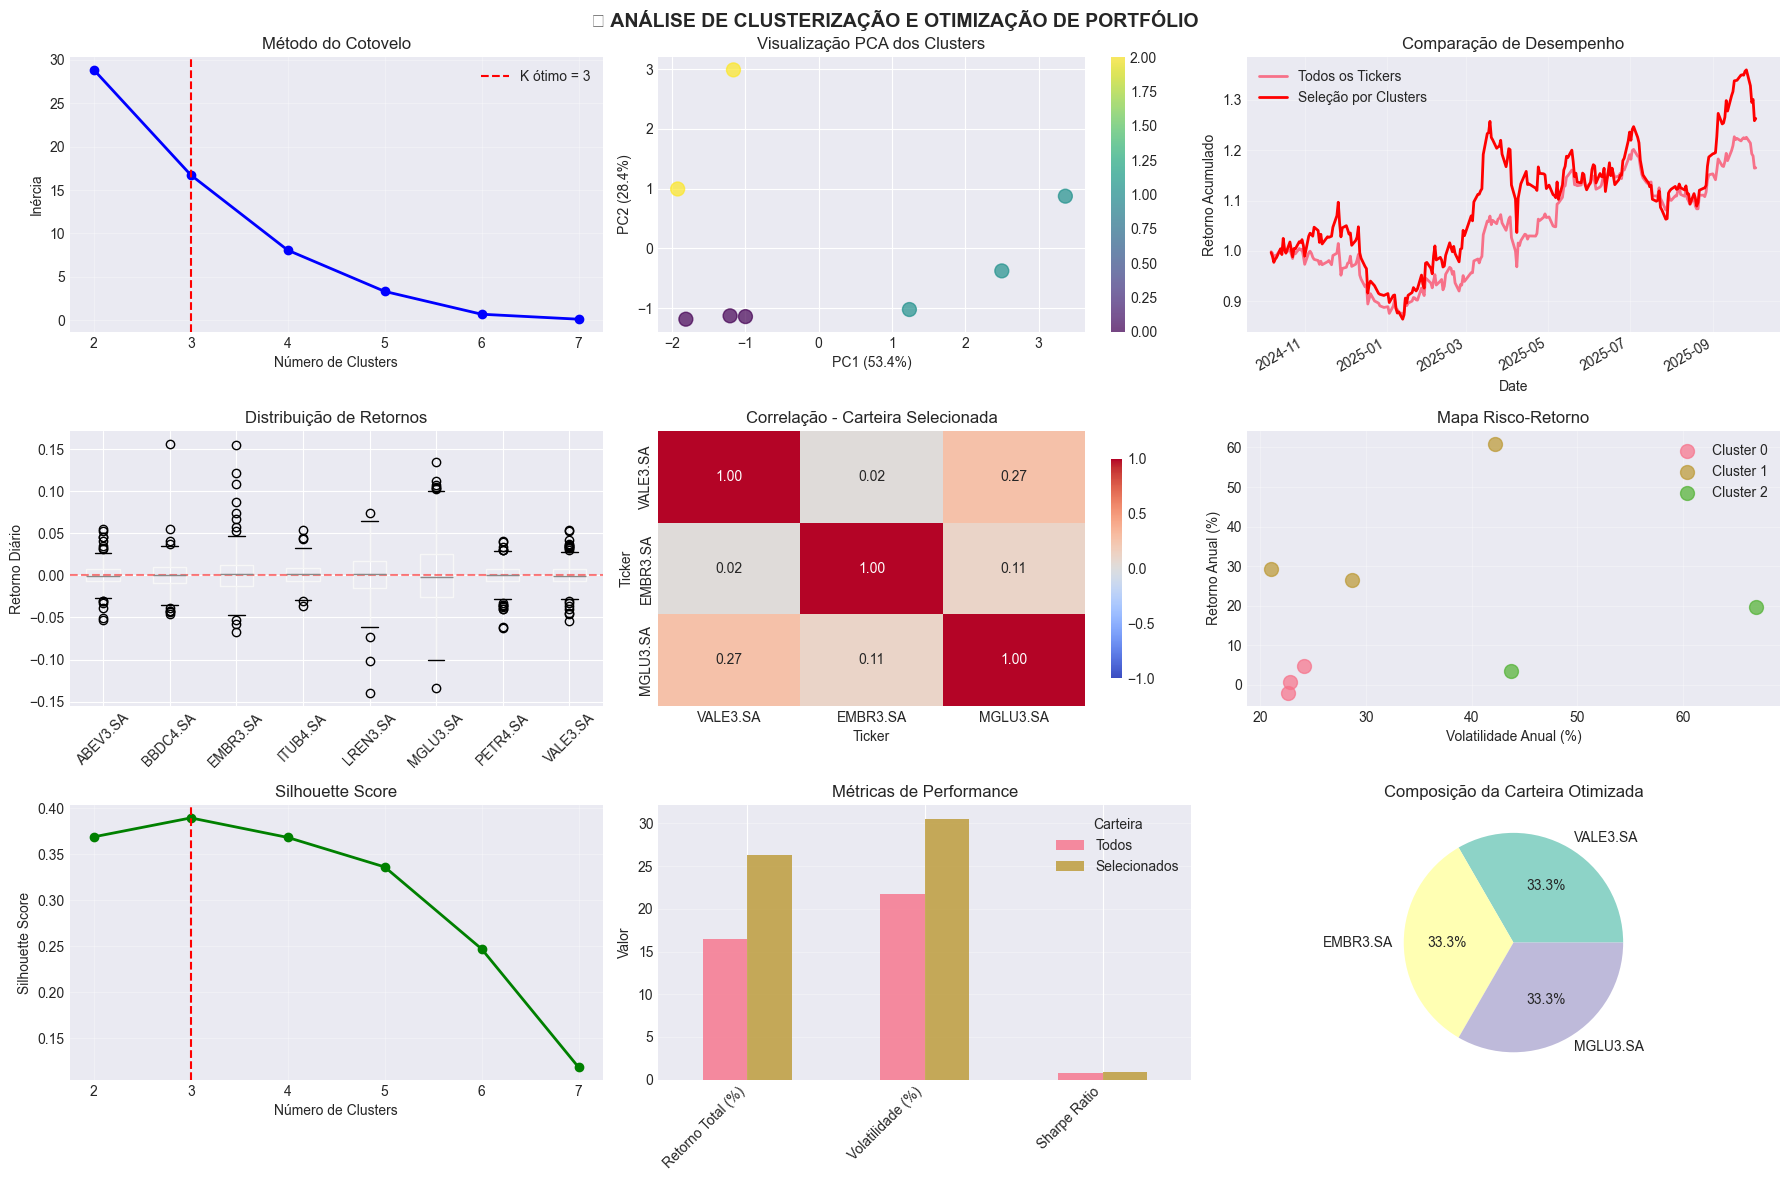

In [ ]:

# =====================================
# VISUALIZAÇÕES
# =====================================
print("\n📈 Gerando visualizações...")

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('📊 ANÁLISE DE CLUSTERIZAÇÃO E OTIMIZAÇÃO DE PORTFÓLIO', fontsize=14, fontweight='bold')

# 1. Método do Cotovelo
ax = axes[0, 0]
if len(K) > 1 and len(inertias) > 1:
    ax.plot(K, inertias, 'bo-', linewidth=2)
    ax.axvline(x=optimal_k, color='red', linestyle='--', label=f'K ótimo = {optimal_k}')
    ax.set_xlabel('Número de Clusters')
    ax.set_ylabel('Inércia')
    ax.set_title('Método do Cotovelo')
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, f'K = {optimal_k}', ha='center', va='center', fontsize=14)
    ax.set_title('Clusters')

# 2. PCA Visualization
ax = axes[0, 1]
if features_scaled.shape[0] > 1 and features_scaled.shape[1] > 1:
    try:
        pca = PCA(n_components=2)
        features_pca = pca.fit_transform(features_scaled)
        scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], 
                           c=clusters, cmap='viridis', s=100, alpha=0.7)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        ax.set_title('Visualização PCA dos Clusters')
        plt.colorbar(scatter, ax=ax)
    except:
        ax.text(0.5, 0.5, 'PCA não disponível', ha='center', va='center')
        ax.set_title('PCA')
else:
    ax.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
    ax.set_title('PCA')

# 3. Comparação de Carteiras
ax = axes[0, 2]
if not retorno_acumulado_all.empty:
    retorno_acumulado_all.plot(ax=ax, label='Todos os Tickers', linewidth=2)
    retorno_acumulado_selected.plot(ax=ax, label='Seleção por Clusters', linewidth=2, color='red')
    ax.set_title('Comparação de Desempenho')
    ax.set_ylabel('Retorno Acumulado')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 4. Distribuição de Retornos
ax = axes[1, 0]
if not retorno.empty:
    retorno.boxplot(ax=ax, rot=45)
    ax.set_title('Distribuição de Retornos')
    ax.set_ylabel('Retorno Diário')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 5. Matriz de Correlação
ax = axes[1, 1]
if len(tickers_selecionados) > 1 and not retorno.empty:
    corr_selected = retorno[tickers_selecionados].corr()
    sns.heatmap(corr_selected, annot=True, fmt='.2f', cmap='coolwarm', 
                vmin=-1, vmax=1, ax=ax, cbar_kws={'shrink': 0.8})
    ax.set_title('Correlação - Carteira Selecionada')
else:
    ax.text(0.5, 0.5, 'N/A', ha='center', va='center')
    ax.set_title('Correlação')

# 6. Risk-Return Map
ax = axes[1, 2]
if not df_combinado.empty:
    for cluster_id in range(optimal_k):
        cluster_data = df_combinado[df_combinado['Cluster'] == cluster_id]
        if len(cluster_data) > 0:
            ax.scatter(cluster_data['Volatilidade']*100, 
                      cluster_data['Retorno_Medio']*100,
                      label=f'Cluster {cluster_id}', s=100, alpha=0.7)
    ax.set_xlabel('Volatilidade Anual (%)')
    ax.set_ylabel('Retorno Anual (%)')
    ax.set_title('Mapa Risco-Retorno')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 7. Silhouette Scores
ax = axes[2, 0]
if len(silhouette_scores) > 1:
    ax.plot(K[:len(silhouette_scores)], silhouette_scores, 'go-', linewidth=2)
    ax.axvline(x=optimal_k, color='red', linestyle='--')
    ax.set_xlabel('Número de Clusters')
    ax.set_ylabel('Silhouette Score')
    ax.set_title('Silhouette Score')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'N/A', ha='center', va='center')
    ax.set_title('Silhouette Score')

# 8. Performance Metrics
ax = axes[2, 1]
try:
    metrics = pd.DataFrame({
        'Todos': [
            (retorno_acumulado_all.iloc[-1] - 1) * 100,
            portfolio_all.std() * np.sqrt(252) * 100,
            (portfolio_all.mean() / portfolio_all.std()) * np.sqrt(252) if portfolio_all.std() > 0 else 0
        ],
        'Selecionados': [
            (retorno_acumulado_selected.iloc[-1] - 1) * 100,
            portfolio_selected.std() * np.sqrt(252) * 100,
            (portfolio_selected.mean() / portfolio_selected.std()) * np.sqrt(252) if portfolio_selected.std() > 0 else 0
        ]
    }, index=['Retorno Total (%)', 'Volatilidade (%)', 'Sharpe Ratio'])
    
    metrics.plot(kind='bar', ax=ax, alpha=0.8)
    ax.set_title('Métricas de Performance')
    ax.set_ylabel('Valor')
    ax.legend(title='Carteira')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
except:
    ax.text(0.5, 0.5, 'Métricas não disponíveis', ha='center', va='center')
    ax.set_title('Métricas')

# 9. Composição da Carteira
ax = axes[2, 2]
if len(tickers_selecionados) > 0:
    sizes = [100/len(tickers_selecionados)] * len(tickers_selecionados)
    colors = plt.cm.Set3(range(len(tickers_selecionados)))
    ax.pie(sizes, labels=tickers_selecionados, colors=colors, autopct='%1.1f%%')
    ax.set_title('Composição da Carteira Otimizada')
else:
    ax.text(0.5, 0.5, 'Sem seleção', ha='center', va='center')
    ax.set_title('Composição')

plt.tight_layout()
plt.show()


In [12]:

# =====================================
# RELATÓRIO FINAL
# =====================================
print("\n" + "=" * 70)
print("🎯 RELATÓRIO FINAL")
print("=" * 70)

print(f"\n📊 Resumo da Análise:")
print(f"   • Ações analisadas: {len(data.columns)}")
print(f"   • Clusters identificados: {optimal_k}")
print(f"   • Ações selecionadas: {len(tickers_selecionados)}")

if not retorno.empty:
    ret_all = (retorno_acumulado_all.iloc[-1] - 1) * 100
    ret_sel = (retorno_acumulado_selected.iloc[-1] - 1) * 100
    
    print(f"\n📈 Performance:")
    print(f"   • Carteira Completa: {ret_all:.2f}%")
    print(f"   • Carteira Otimizada: {ret_sel:.2f}%")
    
    if ret_sel > ret_all:
        print(f"   ✅ A seleção por clusters melhorou o retorno em {ret_sel - ret_all:.2f}%")
    else:
        print(f"   ⚠️ A carteira completa teve melhor desempenho")

print(f"\n💼 Carteira Otimizada:")
for i, ticker in enumerate(tickers_selecionados, 1):
    peso = 100 / len(tickers_selecionados)
    print(f"   {i}. {ticker}: {peso:.1f}%")

print("\n✅ Análise concluída com sucesso!")
print("=" * 70)


🎯 RELATÓRIO FINAL

📊 Resumo da Análise:
   • Ações analisadas: 8
   • Clusters identificados: 3
   • Ações selecionadas: 3

📈 Performance:
   • Carteira Completa: 16.51%
   • Carteira Otimizada: 26.30%
   ✅ A seleção por clusters melhorou o retorno em 9.79%

💼 Carteira Otimizada:
   1. VALE3.SA: 33.3%
   2. EMBR3.SA: 33.3%
   3. MGLU3.SA: 33.3%

✅ Análise concluída com sucesso!
